In [2]:
import pandas as pd
import numpy as np
from cmapPy.pandasGEXpress.parse import parse
import cmapPy.pandasGEXpress.subset_gctoo as sg
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib.colors import ListedColormap

In [3]:
def cell_line_corr(moas, clue_gene, clue_sig_in_SPECS, min_num):
    '''
    Produces correlation heatmap of how different cell lines' transcriptomic profiles differ
    from each other.
    
    Input:
    moas: list of moas to investigate
    clue_gene: row meta data from clue.io transcriptomic profiles
    clue_sig_in_SPECS: column meta data from clue.io transcriptomic profiles in §§§dprvd
    min_num: the least number of transcriptomic profiles necessary to include in corr analysis
    
    Output:
    - produces correlation
    - saves a png figure in PNG_Cell_Line_Investigations
    - prints the cell line and the number of transcriptomic profiles
    '''
    for MOA in moas:
        
        # choosing only landmark genes
        clue_gene["gene_id"] = clue_gene["gene_id"].astype(str)
        landmark_gene_row_ids = clue_gene["gene_id"][clue_gene["feature_space"] == "landmark"]

        # get all samples (across all cell types, doses, and other treatment conditions) with certain MoA
        profile_ids = clue_sig_in_SPECS["sig_id"][clue_sig_in_SPECS["moa"] == MOA]
        tprofiles_gctoo = parse("/scratch2-shared/erikep/level5_beta_trt_cp_n720216x12328.gctx", 
                                      cid= profile_ids, 
                                      rid = landmark_gene_row_ids)

        ### 2. copy the metadata from those samples

        # first, we need to subset all the metadata information from our larger metadata DataFrame
        # col
        tprofiles_sig_id_info = clue_sig_in_SPECS[clue_sig_in_SPECS["moa"] == MOA]

        # row 
        tprofiles_gene_id_info = clue_gene[clue_gene["feature_space"] == "landmark"]

        tprofiles_sig_id_info.set_index("sig_id", inplace=True)
        # now the data frame is indexed by sig_ids consistent with those of the data_df:
        tprofiles_sig_id_info.index

        tprofiles_gene_id_info.set_index("gene_id", inplace=True)
        # now the data frame is indexed by sig_ids consistent with those of the data_df:
        tprofiles_gene_id_info.index

        # set the relevant annotations as a col_metadata_df: 
        tprofiles_gctoo.col_metadata_df = tprofiles_sig_id_info

        # set the relevant annotations as a row_metadata_df: 
        tprofiles_gctoo.row_metadata_df = tprofiles_gene_id_info

        ### 4. From that Metadata, subset if need be

        cell_inames = tprofiles_gctoo.col_metadata_df["cell_iname"].unique()
        
        # remove cell lines that don't have more than a min_num of profiles 
        enough_cellnames = []
        for i in cell_inames:
            tprofiles_cell_line1 = tprofiles_gctoo.col_metadata_df.index[tprofiles_gctoo.col_metadata_df["cell_iname"] == i]
            if len(tprofiles_cell_line1) > min_num:
                   enough_cellnames.append(i)              

        # take mean transcriptomic profile for profiles within cell line and save in list
        all_cell_lines = []
        for i in enough_cellnames:
            # print cell lines and number of profiles that meet criteria
            tprofiles_cell_line1_ids = tprofiles_gctoo.col_metadata_df.index[tprofiles_gctoo.col_metadata_df["cell_iname"] == i]
            print(f' Cell line: {i}, #: {len(tprofiles_cell_line1_ids)}')
            
            tprofiles_cell_line1_ids = list(tprofiles_cell_line1_ids)
            # subset GCToo instance to only include these values 
            tprofiles_line1_gctoo = sg.subset_gctoo(tprofiles_gctoo, cid= tprofiles_cell_line1_ids)
            mean = tprofiles_line1_gctoo.data_df.mean(axis = 1)
            all_cell_lines.append(mean)
        
        # Create a custom colormap with white for masked values
        custom_cmap = ListedColormap(sns.color_palette("coolwarm", as_cmap=True)(np.arange(256)))
        custom_cmap.set_bad(color='white')

        # concatanate into new pandas dataframe
        broster= pd.concat(all_cell_lines,axis = 1)
        corr = broster.corr()
        matrix = np.triu(corr)
            # Plotting Results
        title_string = MOA + ": correlation between different cell lines. Min num of profiles: " + str(min_num)
        plt.figure(figsize=(16,5))
        plt.title(title_string)
        sns.set()
        sns.heatmap(corr*100,
            annot=True,
            fmt='.2g',
            xticklabels=enough_cellnames,
            yticklabels=enough_cellnames,
            mask=matrix,
            cmap=custom_cmap) 

        # Rotate horizontal labels by 45 degrees
        plt.xticks(rotation=45)

        png_directory = "/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/PNG_Cell_Line_Investigations"
        name = png_directory + "/" + MOA +  ".png"
        plt.savefig(name)
        plt.show()


## Downloading data 

In [4]:
# metadata for clue.io data in the SPECS1&2
clue_sig_in_SPECS = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_sig_in_SPECS1&2.csv', delimiter = ",")
# identifying rows with only landmark genes
clue_gene = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_geneinfo_beta.txt', delimiter = "\t")
# downloading information on all of the compounds
compounds_v1v2 = pd.read_csv("/home/jovyan/Tomics-CP-Chem-MoA/data_for_models/compounds_v1v2.csv")

In [5]:
# list of different moas to investigate
erik10 = ["cyclooxygenase inhibitor", "dopamine receptor antagonist","adrenergic receptor antagonist", "phosphodiesterase inhibitor",  "HDAC inhibitor", 
             "histamine receptor antagonist","EGFR inhibitor", "adrenergic receptor agonist", "PARP inhibitor",  "topoisomerase inhibitor"]
cyc_adr = ["cyclooxygenase inhibitor", "adrenergic receptor antagonist"]
cyc_dop = ["cyclooxygenase inhibitor", "dopamine receptor antagonist"]
tian10 = ['Aurora kinase inhibitor', 'tubulin polymerization inhibitor', 'JAK inhibitor', 'protein synthesis inhibitor', 'HDAC inhibitor',
            'topoisomerase inhibitor', 'PARP inhibitor', 'ATPase inhibitor', 'retinoid receptor agonist', 'HSP inhibitor']
phosph = ["phosphodiesterase inhibitor"]

 Cell line: A375, #: 82
 Cell line: HEK293T, #: 16
 Cell line: HA1E, #: 77
 Cell line: HCC515, #: 64
 Cell line: PC3, #: 151
 Cell line: VCAP, #: 96
 Cell line: HEPG2, #: 52
 Cell line: HT29, #: 66
 Cell line: MCF7, #: 180
 Cell line: A549, #: 91
 Cell line: ASC, #: 25
 Cell line: NPC, #: 45
 Cell line: PHH, #: 30
 Cell line: SKB, #: 25
 Cell line: NEU, #: 16
 Cell line: HUH7, #: 31
 Cell line: HPTEC, #: 60
 Cell line: MCF10A, #: 36


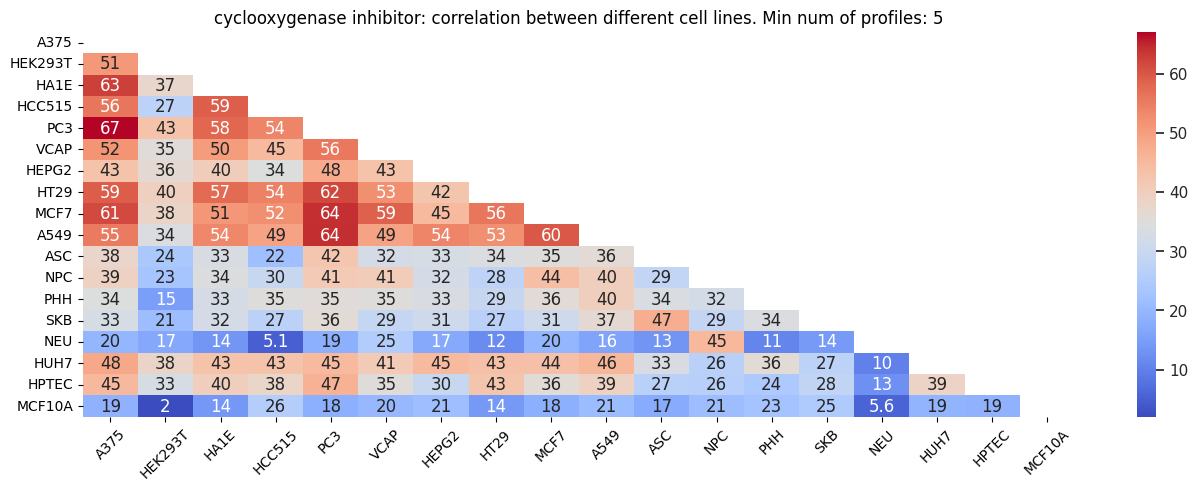

 Cell line: MCF7, #: 282
 Cell line: PC3, #: 183
 Cell line: 22RV1, #: 9
 Cell line: A204, #: 9
 Cell line: A375, #: 83
 Cell line: A549, #: 134
 Cell line: AGS, #: 13
 Cell line: BC3C, #: 9
 Cell line: BEN, #: 9
 Cell line: BICR6, #: 9
 Cell line: BT474, #: 9
 Cell line: CAL29, #: 9
 Cell line: CJM, #: 9
 Cell line: COV434, #: 9
 Cell line: ES2, #: 9
 Cell line: G401, #: 9
 Cell line: GI1, #: 9
 Cell line: GP2D, #: 9
 Cell line: HCC1588, #: 9
 Cell line: HCC95, #: 7
 Cell line: HEC108, #: 15
 Cell line: HEC151, #: 9
 Cell line: HEC1A, #: 9
 Cell line: HEC251, #: 9
 Cell line: HEC265, #: 7
 Cell line: HT29, #: 74
 Cell line: IGR37, #: 9
 Cell line: IM95, #: 9
 Cell line: JHH5, #: 9
 Cell line: JHH7, #: 9
 Cell line: LNCAP, #: 9
 Cell line: MDAMB468, #: 9
 Cell line: MELHO, #: 9
 Cell line: MKN45, #: 9
 Cell line: NCIH1437, #: 9
 Cell line: NCIH1573, #: 9
 Cell line: NCIH2110, #: 9
 Cell line: NCIH2172, #: 9
 Cell line: NCIH838, #: 9
 Cell line: NCIH841, #: 9
 Cell line: OAW28, #: 9
 Ce

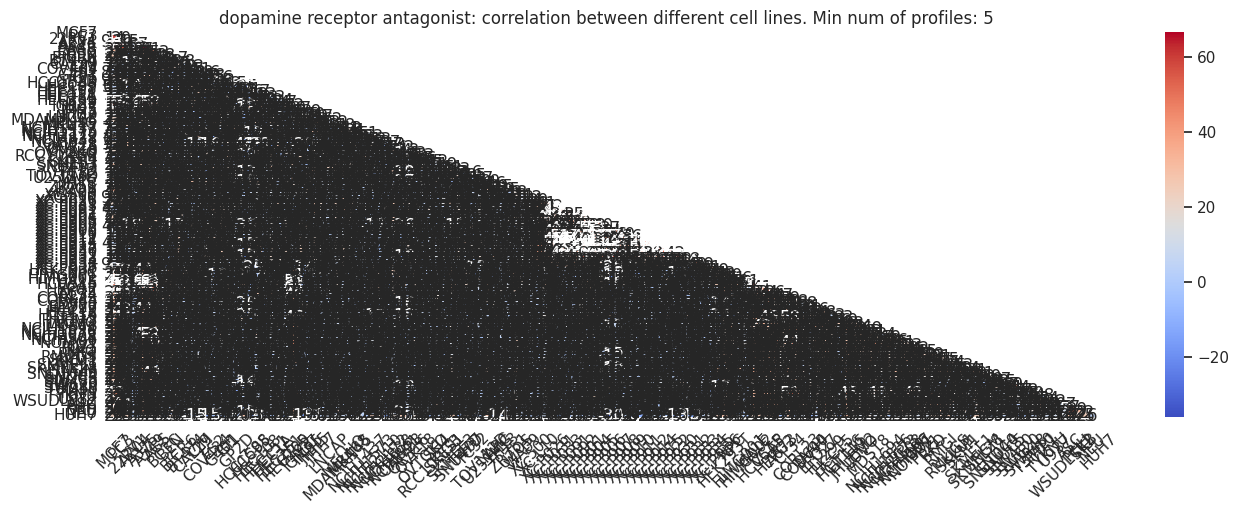

 Cell line: HA1E, #: 41
 Cell line: HCC515, #: 36
 Cell line: PC3, #: 69
 Cell line: VCAP, #: 52
 Cell line: A375, #: 35
 Cell line: HEPG2, #: 20
 Cell line: HT29, #: 35
 Cell line: MCF7, #: 85
 Cell line: A549, #: 50
 Cell line: ASC, #: 13
 Cell line: NPC, #: 23
 Cell line: PHH, #: 15
 Cell line: SKB, #: 13
 Cell line: HPTEC, #: 12
 Cell line: HUH7, #: 10


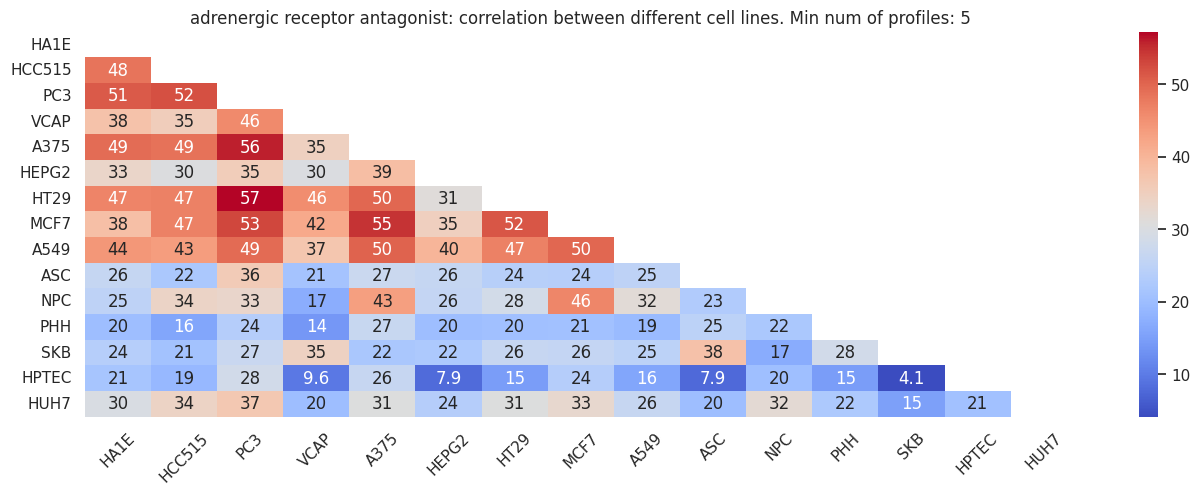

 Cell line: A375, #: 40
 Cell line: A549, #: 78
 Cell line: HT29, #: 40
 Cell line: MCF7, #: 113
 Cell line: PC3, #: 101
 Cell line: U2OS, #: 9
 Cell line: NPC, #: 108
 Cell line: HIMG001, #: 18
 Cell line: HIMG002, #: 18
 Cell line: HA1E, #: 48
 Cell line: HCC515, #: 49
 Cell line: VCAP, #: 63
 Cell line: HEPG2, #: 25
 Cell line: ASC, #: 17
 Cell line: PHH, #: 13
 Cell line: SKB, #: 17
 Cell line: HUH7, #: 13
 Cell line: SHSY5Y, #: 6
 Cell line: SKNSH, #: 6


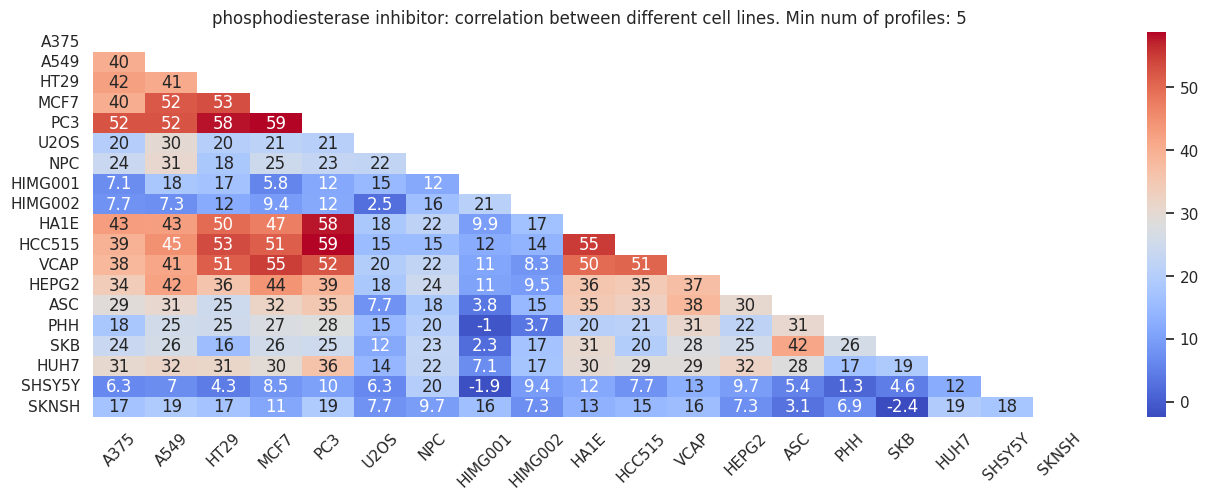

 Cell line: A375, #: 147
 Cell line: A549, #: 340
 Cell line: H1975, #: 6
 Cell line: HEPG2, #: 50
 Cell line: HT29, #: 146
 Cell line: NCIH1975, #: 6
 Cell line: NCIH2073, #: 8
 Cell line: NCIH508, #: 8
 Cell line: NCIH596, #: 8
 Cell line: PC3, #: 368
 Cell line: SKBR3, #: 6
 Cell line: SUDHL4, #: 6
 Cell line: MCF7, #: 493
 Cell line: 22RV1, #: 7
 Cell line: A204, #: 6
 Cell line: AGS, #: 8
 Cell line: BC3C, #: 6
 Cell line: BEN, #: 6
 Cell line: BICR6, #: 6
 Cell line: BT474, #: 6
 Cell line: CAL29, #: 6
 Cell line: CJM, #: 6
 Cell line: COV434, #: 6
 Cell line: G401, #: 6
 Cell line: GI1, #: 6
 Cell line: GP2D, #: 6
 Cell line: HCC1588, #: 6
 Cell line: HCC95, #: 6
 Cell line: HEC108, #: 7
 Cell line: HEC151, #: 6
 Cell line: HEC1A, #: 6
 Cell line: HEC251, #: 6
 Cell line: IGR37, #: 6
 Cell line: IM95, #: 6
 Cell line: JHH5, #: 6
 Cell line: JHH7, #: 6
 Cell line: LNCAP, #: 9
 Cell line: MDAMB468, #: 6
 Cell line: MELHO, #: 6
 Cell line: MKN45, #: 6
 Cell line: NCIH1437, #: 6
 Ce

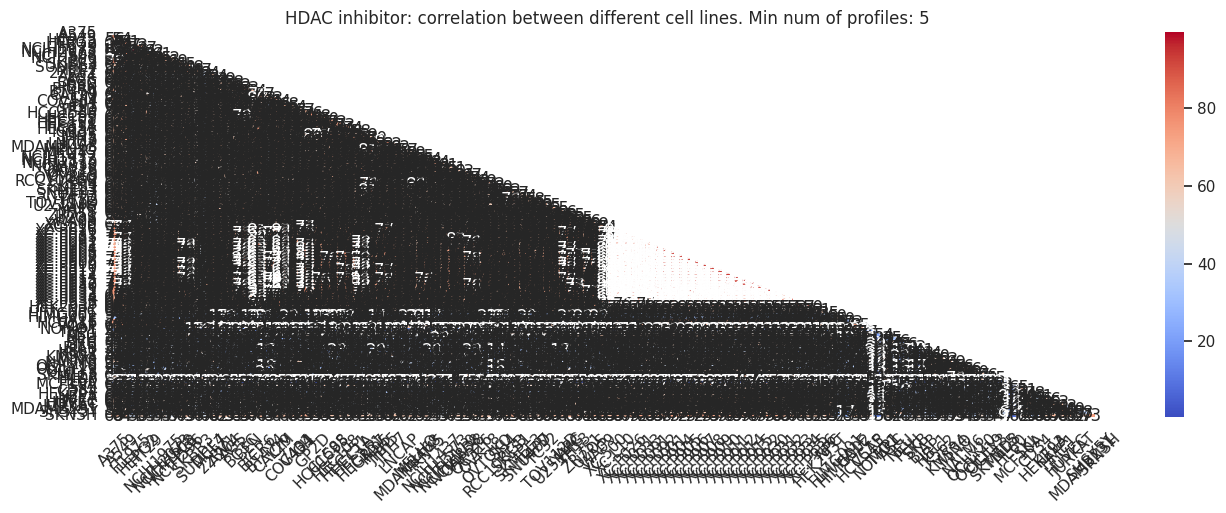

 Cell line: HA1E, #: 37
 Cell line: HCC515, #: 30
 Cell line: PC3, #: 70
 Cell line: VCAP, #: 48
 Cell line: A375, #: 32
 Cell line: HEPG2, #: 22
 Cell line: HT29, #: 32
 Cell line: MCF7, #: 89
 Cell line: A549, #: 47
 Cell line: ASC, #: 12
 Cell line: NPC, #: 12
 Cell line: PHH, #: 15
 Cell line: SKB, #: 12
 Cell line: HUH7, #: 10


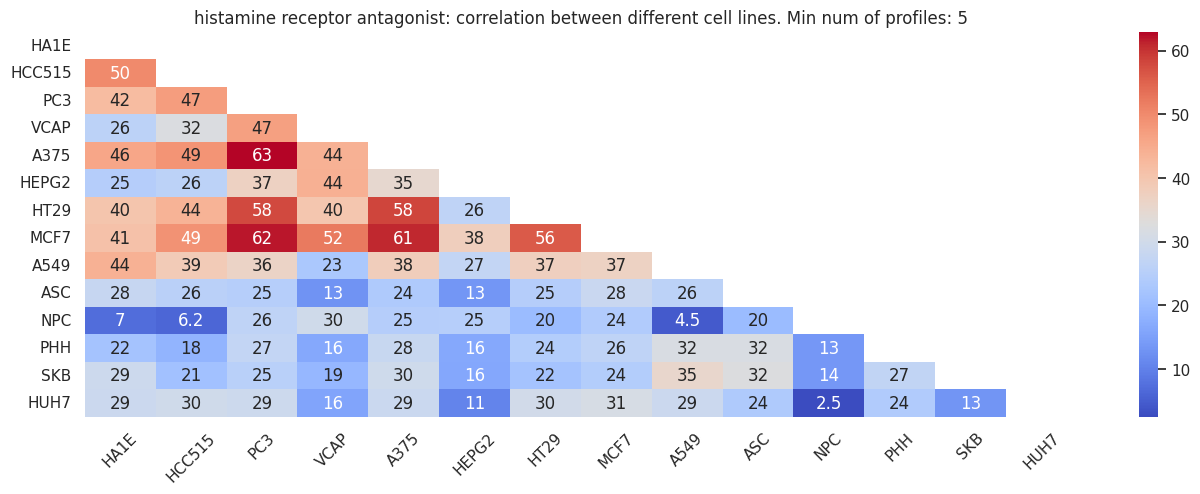

 Cell line: A375, #: 89
 Cell line: A549, #: 183
 Cell line: H1975, #: 24
 Cell line: HEPG2, #: 64
 Cell line: HT29, #: 87
 Cell line: NCIH1975, #: 24
 Cell line: NCIH2073, #: 26
 Cell line: NCIH508, #: 26
 Cell line: NCIH596, #: 26
 Cell line: PC3, #: 122
 Cell line: SKBR3, #: 68
 Cell line: SUDHL4, #: 24
 Cell line: 22RV1, #: 11
 Cell line: A204, #: 11
 Cell line: AGS, #: 14
 Cell line: BC3C, #: 12
 Cell line: BEN, #: 11
 Cell line: BICR6, #: 12
 Cell line: BT474, #: 23
 Cell line: CAL29, #: 11
 Cell line: CJM, #: 12
 Cell line: COV434, #: 12
 Cell line: ES2, #: 11
 Cell line: G401, #: 12
 Cell line: GI1, #: 10
 Cell line: GP2D, #: 12
 Cell line: HCC1588, #: 11
 Cell line: HCC95, #: 10
 Cell line: HEC108, #: 13
 Cell line: HEC151, #: 12
 Cell line: HEC1A, #: 12
 Cell line: HEC251, #: 12
 Cell line: HEC265, #: 8
 Cell line: IGR37, #: 12
 Cell line: IM95, #: 12
 Cell line: JHH5, #: 11
 Cell line: JHH7, #: 12
 Cell line: LNCAP, #: 23
 Cell line: MCF7, #: 190
 Cell line: MDAMB468, #: 11


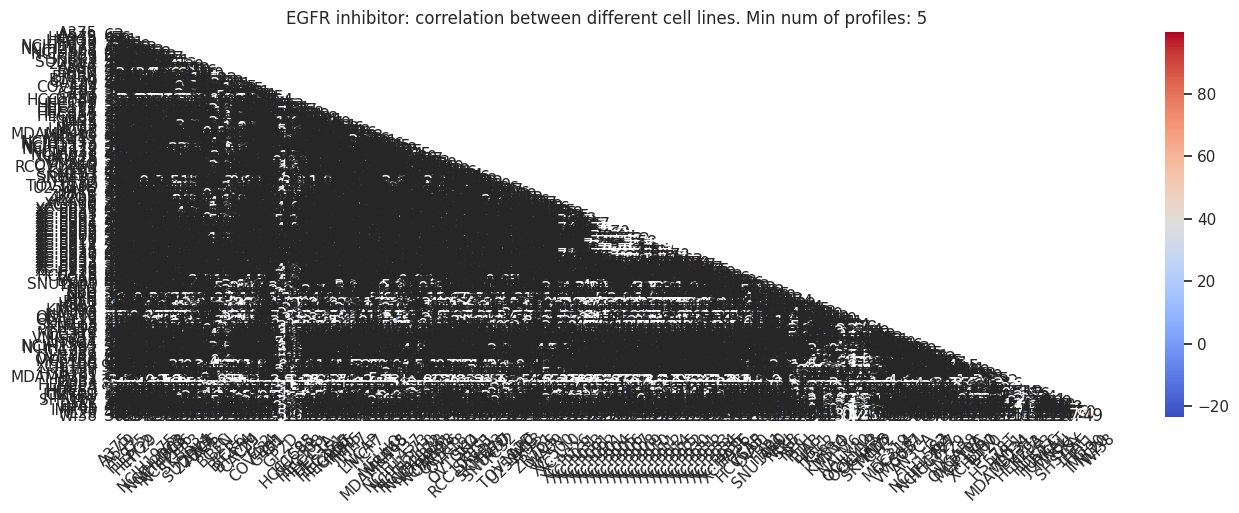

 Cell line: 22RV1, #: 6
 Cell line: A204, #: 6
 Cell line: A375, #: 32
 Cell line: A549, #: 58
 Cell line: AGS, #: 6
 Cell line: BC3C, #: 6
 Cell line: BEN, #: 6
 Cell line: BICR6, #: 6
 Cell line: BT474, #: 6
 Cell line: CAL29, #: 6
 Cell line: CJM, #: 6
 Cell line: COV434, #: 6
 Cell line: ES2, #: 6
 Cell line: G401, #: 6
 Cell line: GI1, #: 6
 Cell line: GP2D, #: 6
 Cell line: HCC1588, #: 6
 Cell line: HCC95, #: 6
 Cell line: HEC108, #: 7
 Cell line: HEC151, #: 6
 Cell line: HEC1A, #: 6
 Cell line: HEC251, #: 6
 Cell line: HT29, #: 32
 Cell line: IGR37, #: 6
 Cell line: IM95, #: 6
 Cell line: JHH5, #: 6
 Cell line: JHH7, #: 6
 Cell line: LNCAP, #: 6
 Cell line: MCF7, #: 84
 Cell line: MDAMB468, #: 6
 Cell line: MELHO, #: 6
 Cell line: MKN45, #: 6
 Cell line: NCIH1573, #: 6
 Cell line: NCIH2110, #: 6
 Cell line: NCIH2172, #: 6
 Cell line: NCIH838, #: 6
 Cell line: NCIH841, #: 6
 Cell line: OC316, #: 6
 Cell line: OVK18, #: 6
 Cell line: PC3, #: 61
 Cell line: RCC10RGB, #: 6
 Cell lin

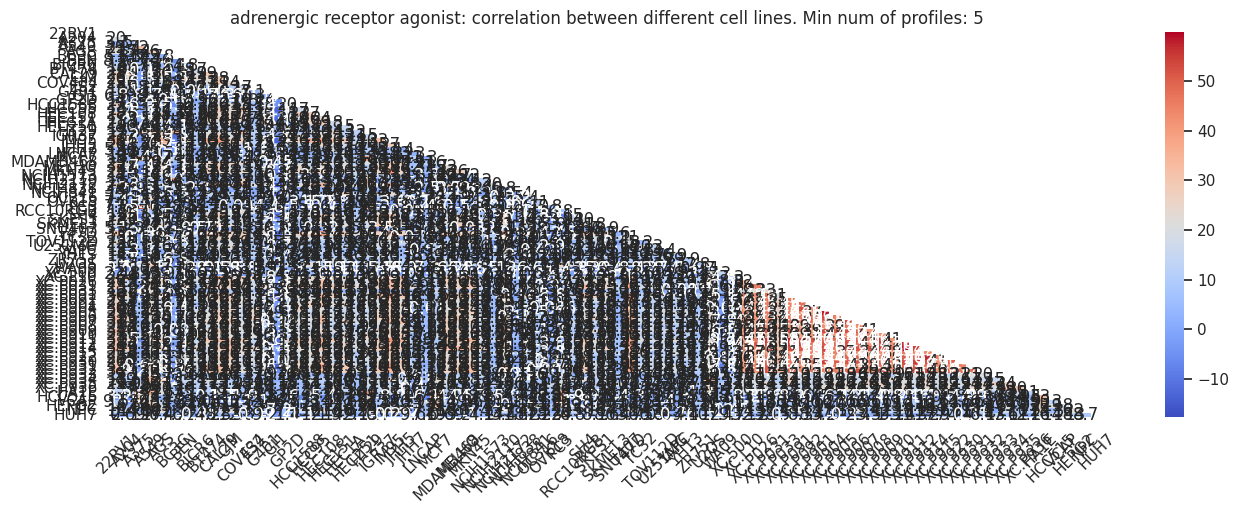

 Cell line: 22RV1, #: 9
 Cell line: A204, #: 9
 Cell line: A375, #: 28
 Cell line: A549, #: 173
 Cell line: AGS, #: 15
 Cell line: BC3C, #: 9
 Cell line: BEN, #: 9
 Cell line: BICR6, #: 9
 Cell line: BT474, #: 9
 Cell line: CAL29, #: 9
 Cell line: CJM, #: 9
 Cell line: COV434, #: 9
 Cell line: ES2, #: 9
 Cell line: G401, #: 9
 Cell line: GI1, #: 9
 Cell line: GP2D, #: 9
 Cell line: HCC1588, #: 9
 Cell line: HCC95, #: 9
 Cell line: HEC108, #: 14
 Cell line: HEC151, #: 9
 Cell line: HEC1A, #: 8
 Cell line: HEC251, #: 9
 Cell line: HEC265, #: 8
 Cell line: HT29, #: 29
 Cell line: IGR37, #: 9
 Cell line: IM95, #: 9
 Cell line: JHH5, #: 9
 Cell line: JHH7, #: 9
 Cell line: LNCAP, #: 9
 Cell line: MCF7, #: 184
 Cell line: MDAMB468, #: 9
 Cell line: MELHO, #: 9
 Cell line: MKN45, #: 9
 Cell line: NCIH1437, #: 9
 Cell line: NCIH1573, #: 9
 Cell line: NCIH2110, #: 9
 Cell line: NCIH2172, #: 9
 Cell line: NCIH838, #: 9
 Cell line: NCIH841, #: 9
 Cell line: OAW28, #: 9
 Cell line: OC316, #: 9
 Ce

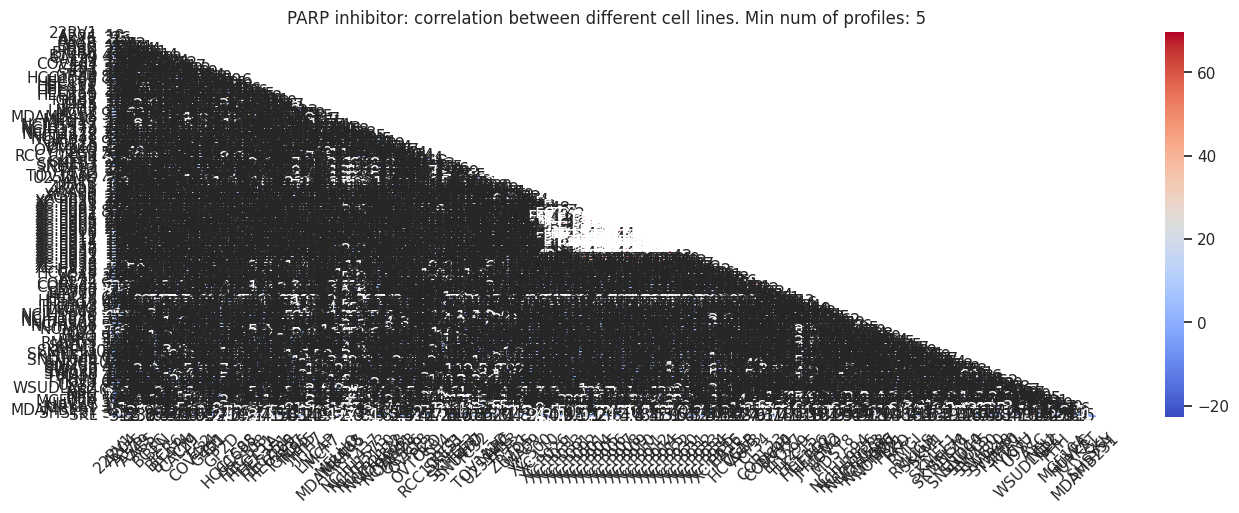

 Cell line: A375, #: 38
 Cell line: A549, #: 152
 Cell line: H1975, #: 6
 Cell line: HEPG2, #: 29
 Cell line: HT29, #: 53
 Cell line: NCIH1975, #: 6
 Cell line: NCIH2073, #: 7
 Cell line: NCIH508, #: 7
 Cell line: NCIH596, #: 7
 Cell line: PC3, #: 110
 Cell line: SKBR3, #: 14
 Cell line: MCF7, #: 194
 Cell line: 22RV1, #: 6
 Cell line: A204, #: 6
 Cell line: AGS, #: 7
 Cell line: BC3C, #: 6
 Cell line: BEN, #: 6
 Cell line: BT474, #: 6
 Cell line: CAL29, #: 6
 Cell line: COV434, #: 6
 Cell line: ES2, #: 6
 Cell line: G401, #: 6
 Cell line: HCC1588, #: 6
 Cell line: HEC151, #: 6
 Cell line: HEC1A, #: 6
 Cell line: HEC251, #: 6
 Cell line: HEC265, #: 6
 Cell line: JHH5, #: 6
 Cell line: JHH7, #: 6
 Cell line: LNCAP, #: 12
 Cell line: MDAMB468, #: 6
 Cell line: MELHO, #: 6
 Cell line: MKN45, #: 6
 Cell line: NCIH1437, #: 6
 Cell line: NCIH1573, #: 6
 Cell line: NCIH2110, #: 6
 Cell line: NCIH2172, #: 6
 Cell line: NCIH841, #: 6
 Cell line: OAW28, #: 6
 Cell line: OC316, #: 6
 Cell line: O

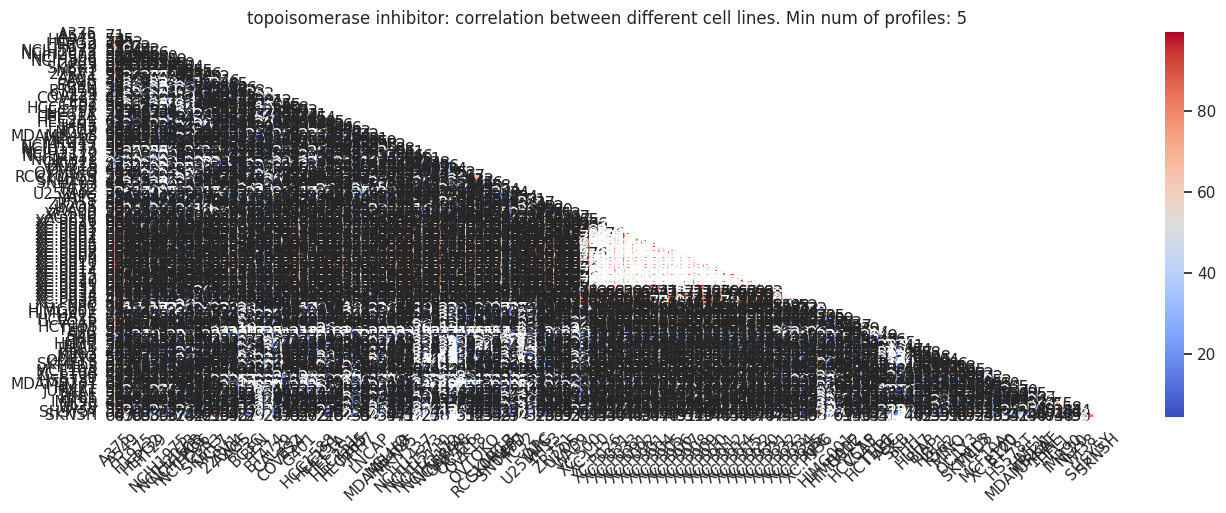

In [6]:
cell_line_corr(erik10, clue_gene, clue_sig_in_SPECS, 5)